In [76]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

## data prepare

In [77]:

data = pd.read_csv("data/cs-training.csv", index_col = 0)
test_set = pd.read_csv("data/cs-test.csv", index_col = 0)
test_Y = pd.read_csv("data/sampleEntry.csv", index_col = 0)
data.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [78]:
# missing value
print("Missing value:","\n",data.isna().sum(axis=0))

# fill nan with mean
data["MonthlyIncome"] = data["MonthlyIncome"].fillna(value = data["MonthlyIncome"].mean())
data["NumberOfDependents"] = data["NumberOfDependents"].fillna(value = data["NumberOfDependents"].mean())

Missing value: 
 SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64


In [79]:
X = data.drop(columns="SeriousDlqin2yrs")
Y = data[["SeriousDlqin2yrs"]]
Y = np.array(Y["SeriousDlqin2yrs"])

X_test = test_set.drop(columns="SeriousDlqin2yrs")

# Use mean to fill nan
X_test["MonthlyIncome"] = X_test["MonthlyIncome"].fillna(value = X_test["MonthlyIncome"].mean())
X_test["NumberOfDependents"] = X_test["NumberOfDependents"].fillna(value = X_test["NumberOfDependents"].mean())
test_Y.loc[test_Y["Probability"] > 0.5,:] = 1
test_Y.loc[test_Y["Probability"] <= 0.5,:] = 0

In [80]:
# scale X

sc = StandardScaler()
sc.fit(X)
X_std = sc.transform(X)
X_test_std = sc.transform(X_test)

## PCA

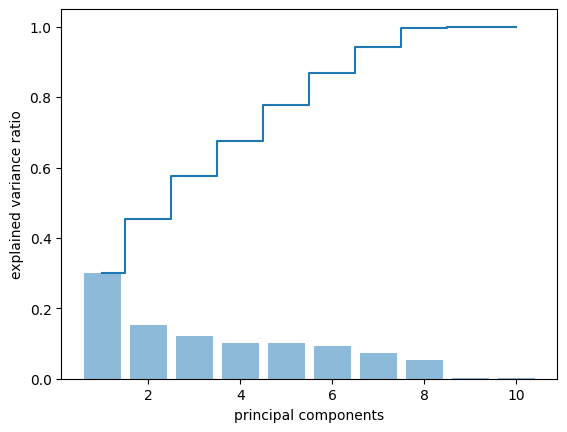

In [81]:
# feature extraction with PCA


pca = PCA()
X_std_pca = pca.fit_transform(X_std)

plt.bar(range(1, 11), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, 11), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('explained variance ratio')
plt.xlabel('principal components')

plt.show()

In [82]:
# use 8 components
pca = PCA(n_components=8)
X_pca = pca.fit_transform(X_std)
X_test_pca = pca.transform(X_test_std)

## ML pipeline

In [83]:

seed = 2024

# split train and test set

X_train, X_vali, y_train, y_vali = train_test_split(X, Y, test_size=0.3, random_state=1, stratify=Y)

### logistic regression
* penalty
* C

In [84]:


pipeline_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=8),
                        LogisticRegression(random_state=1, solver='lbfgs'))
scorer = make_scorer(f1_score, pos_label=1)

In [85]:
C_range = [0.001,0.01, 0.1, 1.0, 10.0]

param_grid = [{'logisticregression__C': C_range,
               'logisticregression__penalty': ['l2']},
              {'logisticregression__C': C_range,
               'logisticregression__penalty': ['l1']}]

gs = GridSearchCV(estimator = pipeline_lr,
                  param_grid=param_grid,
                  scoring=scorer,
                  cv=5, verbose=3)

gs = gs.fit(X_train, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END logisticregression__C=0.001, logisticregression__penalty=l2;, score=0.022 total time=   0.0s
[CV 2/5] END logisticregression__C=0.001, logisticregression__penalty=l2;, score=0.032 total time=   0.0s
[CV 3/5] END logisticregression__C=0.001, logisticregression__penalty=l2;, score=0.032 total time=   0.0s
[CV 4/5] END logisticregression__C=0.001, logisticregression__penalty=l2;, score=0.035 total time=   0.0s
[CV 5/5] END logisticregression__C=0.001, logisticregression__penalty=l2;, score=0.019 total time=   0.0s
[CV 1/5] END logisticregression__C=0.01, logisticregression__penalty=l2;, score=0.022 total time=   0.0s
[CV 2/5] END logisticregression__C=0.01, logisticregression__penalty=l2;, score=0.032 total time=   0.0s
[CV 3/5] END logisticregression__C=0.01, logisticregression__penalty=l2;, score=0.031 total time=   0.0s
[CV 4/5] END logisticregression__C=0.01, logisticregression__penalty=l2;, score=0.035 total ti

In [86]:
print(gs.best_score_)
print(gs.best_params_)

0.028033499667709065
{'logisticregression__C': 0.001, 'logisticregression__penalty': 'l2'}


In [87]:

pipeline_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=8),
                        LogisticRegression(random_state=seed,penalty = "l2",C=0.001, solver='lbfgs'))

pipeline_lr.fit(X_train, y_train)
y_pred = pipeline_lr.predict(X_test)


print('precision: %.4f' % precision_score(y_true=test_Y, y_pred=y_pred))
print('recall: %.4f' % recall_score(y_true=test_Y, y_pred=y_pred))
print('F1: %.4f' % f1_score(y_true=test_Y, y_pred=y_pred))
print('accuracy: %.4f' % accuracy_score(test_Y,y_pred))

precision: 0.6000
recall: 0.0757
F1: 0.1344
accuracy: 0.9836


## random forest
* max_depth
* n_estimators

In [88]:



pipeline_rf = make_pipeline(StandardScaler(),
                        PCA(n_components=8),
                        RandomForestClassifier(criterion='gini',random_state=seed))
scorer = make_scorer(f1_score, pos_label=1)

In [89]:
n_estimators = [20,40,60,80]
max_depth = [3,5,7]

param_grid = [{'randomforestclassifier__n_estimators': n_estimators,
               'randomforestclassifier__max_depth': max_depth}]

gs = GridSearchCV(estimator = pipeline_rf,
                  param_grid=param_grid,
                  scoring=scorer,
                  cv=5, verbose=3)

gs = gs.fit(X_train, y_train)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END randomforestclassifier__max_depth=3, randomforestclassifier__n_estimators=20;, score=0.000 total time=   0.9s
[CV 2/5] END randomforestclassifier__max_depth=3, randomforestclassifier__n_estimators=20;, score=0.000 total time=   0.9s
[CV 3/5] END randomforestclassifier__max_depth=3, randomforestclassifier__n_estimators=20;, score=0.000 total time=   0.9s
[CV 4/5] END randomforestclassifier__max_depth=3, randomforestclassifier__n_estimators=20;, score=0.000 total time=   0.9s
[CV 5/5] END randomforestclassifier__max_depth=3, randomforestclassifier__n_estimators=20;, score=0.000 total time=   0.9s
[CV 1/5] END randomforestclassifier__max_depth=3, randomforestclassifier__n_estimators=40;, score=0.000 total time=   1.9s
[CV 2/5] END randomforestclassifier__max_depth=3, randomforestclassifier__n_estimators=40;, score=0.000 total time=   1.9s
[CV 3/5] END randomforestclassifier__max_depth=3, randomforestclassifier__n_es

In [90]:
print(gs.best_score_)
print(gs.best_params_)

0.08837561288539256
{'randomforestclassifier__max_depth': 7, 'randomforestclassifier__n_estimators': 40}


In [91]:
pipeline_rf = make_pipeline(StandardScaler(),
                        PCA(n_components=8),
                        RandomForestClassifier(random_state=seed,n_estimators =40, max_depth = 7))

pipeline_rf.fit(X_train, y_train)
y_pred = pipeline_rf.predict(X_test)


print('precision: %.4f' % precision_score(y_true=test_Y, y_pred=y_pred))
print('recall: %.4f' % recall_score(y_true=test_Y, y_pred=y_pred))
print('F1: %.4f' % f1_score(y_true=test_Y, y_pred=y_pred))
print('accuracy: %.4f' % accuracy_score(test_Y,y_pred))

precision: 0.8155
recall: 0.1607
F1: 0.2685
accuracy: 0.9853


## XGBoost
* max_depth
* n_estimators

In [92]:



pipeline_xgb = make_pipeline(StandardScaler(),
                        PCA(n_components=8),
                        XGBClassifier(random_state=seed))
scorer = make_scorer(f1_score, pos_label=1)

In [93]:

n_estimators = [10,20,30]
max_depth = [3,5,7,9]

param_grid = [{'xgbclassifier__n_estimators': n_estimators,
               'xgbclassifier__max_depth': max_depth}]

gs = GridSearchCV(estimator = pipeline_xgb,
                  param_grid=param_grid,
                  scoring=scorer,
                  cv=5, verbose=3)
gs = gs.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END xgbclassifier__max_depth=3, xgbclassifier__n_estimators=10;, score=0.210 total time=   0.0s
[CV 2/5] END xgbclassifier__max_depth=3, xgbclassifier__n_estimators=10;, score=0.202 total time=   0.0s
[CV 3/5] END xgbclassifier__max_depth=3, xgbclassifier__n_estimators=10;, score=0.242 total time=   0.0s
[CV 4/5] END xgbclassifier__max_depth=3, xgbclassifier__n_estimators=10;, score=0.202 total time=   0.0s
[CV 5/5] END xgbclassifier__max_depth=3, xgbclassifier__n_estimators=10;, score=0.222 total time=   0.0s
[CV 1/5] END xgbclassifier__max_depth=3, xgbclassifier__n_estimators=20;, score=0.231 total time=   0.0s
[CV 2/5] END xgbclassifier__max_depth=3, xgbclassifier__n_estimators=20;, score=0.227 total time=   0.0s
[CV 3/5] END xgbclassifier__max_depth=3, xgbclassifier__n_estimators=20;, score=0.264 total time=   0.0s
[CV 4/5] END xgbclassifier__max_depth=3, xgbclassifier__n_estimators=20;, score=0.233 total time=  

In [94]:
print(gs.best_score_)
print(gs.best_params_)

0.2491669362383267
{'xgbclassifier__max_depth': 9, 'xgbclassifier__n_estimators': 30}


In [95]:

pipeline_xgb = make_pipeline(StandardScaler(),
                        PCA(n_components=8),
                        XGBClassifier(random_state=seed, n_estimators =  30, max_depth = 9))

pipeline_xgb.fit(X_train, y_train)
y_pred = pipeline_xgb.predict(X_test)


print('precision: %.4f' % precision_score(y_true=test_Y, y_pred=y_pred))
print('recall: %.4f' % recall_score(y_true=test_Y, y_pred=y_pred))
print('F1: %.4f' % f1_score(y_true=test_Y, y_pred=y_pred))
print('accuracy: %.4f' % accuracy_score(test_Y,y_pred))

precision: 0.4923
recall: 0.6199
F1: 0.5488
accuracy: 0.9829
